Order-of-magnitude estimates for outdoor studies of MCB at different scales
===

In [1]:
#Load libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import ticker
from scipy.stats import lognorm
import miepython as mie

In [2]:
#Useful constants
S = 1360/4 #Annual mean diurnal mean insolation, W m-2
Re = 6.371*1e6 #Earth radius, m
h = 1000 #m, typical MBL height
Nspray = 1e16 #number s-1, spray rate
U = 7 #m s-1, typcial wind speed

x = np.logspace(np.log10(1),np.log10(100000),10000) #nm, particle diameters

In [3]:
#Useful functions

def dNdlogD(x,N,Dg,sg):
    """
    Lognormal particle size distribution dN/dlogD
    
    Parameters
    ----------
    x : nm
    Particle diameter to evaluate function at
    
    N : cm-3
    Total number concentration (zeroth moment of PSD)
    
    Dg : nm
    Geometric mean diameter
    
    sg : 1
    Geometric standard deviation
    
    Returns
    -------
    dNdlogD : cm-3
    Particle size distribution (dN/dlogD) value at diameter x
    """
    return N/np.sqrt(2*np.pi)/np.log(sg)*np.exp(-(np.log(x)-np.log(Dg))**2/2/np.log(sg)**2)

def M(x,Dg,sg,dt):
    """
    Total mass for a sprayer at 1e16 s-1
    
    Parameters
    ----------
    x : nm
    Particle diameter to evaluate function at
    
    Dg : nm
    Geometric mean diameter
    
    sg : 1
    Geometric standard deviation
    
    dt : s
    Spraying time
    
    Returns
    -------
    M : Tg
    Total injected salt mass for sprayer
    """
    rho = 2165 #kg m-3, density of solid NaCl
    Vp = np.pi/6*(x*1e-9)**3 #m3, particle volume
    
    return np.sum(rho*Vp*dNdlogD(x,Nspray*dt,Dg,sg)*np.gradient(x)/x)*1e-9 #Tg

def dT(E,t):
    """
    Global temperature perturbation from energy (PJ) spread out globally using a simple mixed-layer model
    
    Parameters
    ----------
    E : PJ
    Total energy perturbation
    
    t : s
    Duration of perturbation
    
    Returns
    -------
    dT : K
    Peak temperature perturbation
    """
    
    #Emulator values for CESM2 from Smith et al. (2021), JGRA
    lmda = -0.72 #W m-2 K-1
    eps = 1.73 #1
    gma = 0.64 #W m-2 K-1
    cpm = 8.33*(365.25*24*3600) #W m-2 K-1 s
    k = eps*gma-lmda

    F = (E*1e15)/t/(4*np.pi*Re**2)
    
    T = F/k*(1-np.exp(-k/cpm*t))
    return T #K    

def dTl(F,t,dy=100*1000):
    """
    Local temperature perturbation from energy (W m-2) spread out locally using a simple mixed-layer model
        
    Parameters
    ----------
    F : W m-2
    Local radiative forcing
    
    t : s
    Duration of perturbation
    
    dy : m
    Characteristic length scale (default: 100 km)
    
    Returns
    -------
    dT : K
    Peak temperature perturbation
    """
    
    #Emulator values for CESM2 from Smith et al. (2021), JGRA
    lmda = -0.72 #W m-2 K-1
    eps = 1.73 #1
    gma = 0.64 #W m-2 K-1
    cpm = 8.33*(365.25*24*3600) #W m-2 K-1 s
    D = 3000 #m2 s-1
    eta = cpm*4*D/dy**2 #W m-2 K-1
    
    k = eta+eps*gma-lmda
    
    T = F/k*(1-np.exp(-k/cpm*t))
    return T #K

In [4]:
#Set Mie values
Q = mie.efficiencies(1.5, x, 550)[0] #Evaluated at 550 nm

Figure: Explaining particle size distributions
=

In [5]:
#Assumed number concentration for MCB and MSB sprayers
N = 250

In [6]:
#Background aerosol estimate: 25/cc of MAM7 fine sea salt and 0.2/cc of MAM7 coarse sea salt
dNdlogD_mam7 = dNdlogD(x,N=25,Dg=(0.095+0.56)/2*1000,sg=2)+dNdlogD(x,N=0.2,Dg=(0.63+3.70)/2*1000,sg=2)
dNdlogD_mam7_eff = dNdlogD(x,N=25,Dg=2*(0.095+0.56)/2*1000,sg=2)+dNdlogD(x,N=0.2,Dg=2*(0.63+3.70)/2*1000,sg=2) #Doubling in size for 80% RH

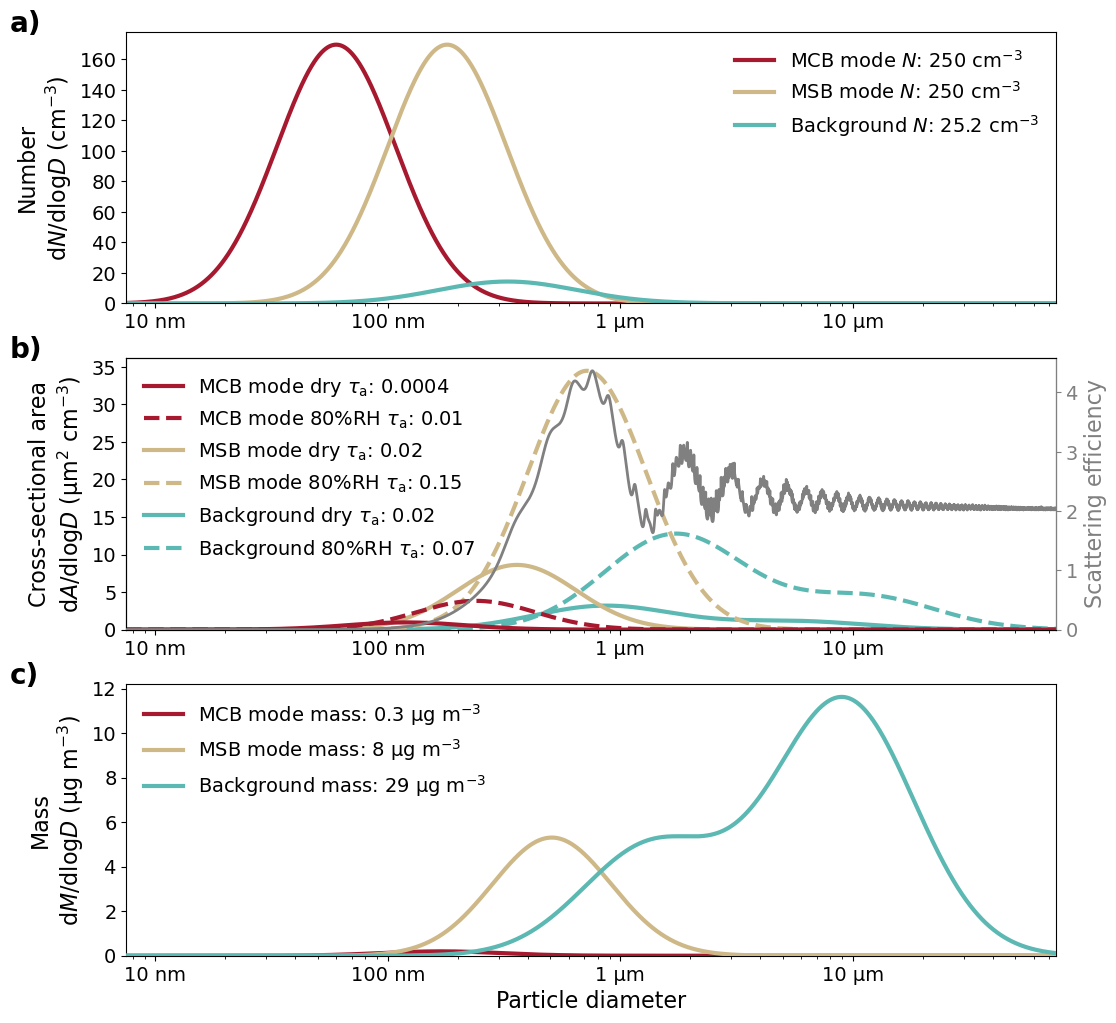

In [7]:
#
###Make plot of number, surface area, and mass distributions
#

plt.figure(figsize=(12,12))
plt.clf()
fs = 16

#
###Number concentration
#
ax1 = plt.subplot(3,1,1)

#Aitken mode
y = dNdlogD(x,N=N,Dg=60,sg=1.8)
plt.plot(x,y,label=r'MCB mode $N$: %i $\mathrm{cm}^{-3}$' % np.sum(y*np.gradient(x)/x),c='#A6192E',lw=3)

#Accumulation mode
y = dNdlogD(x,N=N,Dg=180,sg=1.8)
plt.plot(x,y,label='MSB mode $N$: %i $\mathrm{cm}^{-3}$' % np.sum(y*np.gradient(x)/x),c='#CEB888',lw=3)

#Background
plt.plot(x,dNdlogD_mam7,label='Background $N$: %.1f $\mathrm{cm}^{-3}$' % np.sum(dNdlogD_mam7*np.gradient(x)/x),c='#5CB8B2',lw=3)

plt.xscale('log')
plt.legend(fontsize=fs-2,frameon=False)
plt.xlim(7.5,75000)
plt.ylim(0)
plt.ylabel('Number\n%s' % (r'd$N$/dlog$D$ ($\mathrm{cm}^{-3}$)'),fontsize=fs)
plt.yticks(fontsize=fs-2)
plt.xticks([10,100,1000,10000],['10 nm','100 nm','1 µm','10 µm'],fontsize=fs-2)

ax1.text(-.125,1,s='a)',transform = ax1.transAxes,fontsize=fs+4,fontweight='bold')

#
###Cross-sectional area; AOD assuming constant concentration over 1 km MBL
#
ax2 = plt.subplot(3,1,2)

#Aitken mode
y = np.pi*(x/2*1e-3)**2*dNdlogD(x,N=N,Dg=60,sg=1.8) #um2 cm-3
A = np.pi*(x*1e-9/2)**2*dNdlogD(x,N=N,Dg=60,sg=1.8)*1e6 #m-1
tau = np.sum(Q*A*np.gradient(x)/x*h)
plt.plot(x,y,label=r'MCB mode dry $\tau_\mathrm{a}$: %.4f' % tau,c='#A6192E',lw=3,zorder=10)
y = np.pi*(x/2*1e-3)**2*dNdlogD(x,N=N,Dg=2*60,sg=1.8) #um2 cm-3
A = np.pi*(x*1e-9/2)**2*dNdlogD(x,N=N,Dg=2*60,sg=1.8)*1e6 #m-1
tau = np.sum(Q*A*np.gradient(x)/x*h)
plt.plot(x,y,label=r'MCB mode 80%%RH $\tau_\mathrm{a}$: %.2f' % tau,c='#A6192E',lw=3,ls='dashed',zorder=9)

#Accumulation mode
y = np.pi*(x/2*1e-3)**2*dNdlogD(x,N=N,Dg=180,sg=1.8) #um2 cm-3
A = np.pi*(x*1e-9/2)**2*dNdlogD(x,N=N,Dg=180,sg=1.8)*1e6 #m-1
tau = np.sum(Q*A*np.gradient(x)/x*h)
plt.plot(x,y,label=r'MSB mode dry $\tau_\mathrm{a}$: %.2f' % tau,c='#CEB888',lw=3,zorder=8)
y = np.pi*(x/2*1e-3)**2*dNdlogD(x,N=N,Dg=2*180,sg=1.8) #um2 cm-3
A = np.pi*(x*1e-9/2)**2*dNdlogD(x,N=N,Dg=2*180,sg=1.8)*1e6 #m-1
tau = np.sum(Q*A*np.gradient(x)/x*h)
plt.plot(x,y,label=r'MSB mode 80%%RH $\tau_\mathrm{a}$: %.2f' % tau,c='#CEB888',lw=3,ls='dashed',zorder=7)

#Background
y = np.pi*(x/2*1e-3)**2*dNdlogD_mam7 #um2 cm-3
A = np.pi*(x*1e-9/2)**2*dNdlogD_mam7*1e6 #m-1
tau = np.sum(Q*A*np.gradient(x)/x*h)
plt.plot(x,y,label=r'Background dry $\tau_\mathrm{a}$: %.2f' % tau,c='#5CB8B2',lw=3,zorder=6)
y = np.pi*(x/2*1e-3)**2*dNdlogD_mam7_eff #um2 cm-3
A = np.pi*(x*1e-9/2)**2*dNdlogD_mam7_eff*1e6 #m-1
tau = np.sum(Q*A*np.gradient(x)/x*h)
plt.plot(x,y,label=r'Background 80%%RH $\tau_\mathrm{a}$: %.2f' % tau,c='#5CB8B2',lw=3,ls='dashed',zorder=5)

plt.xscale('log')
plt.legend(fontsize=fs-2,frameon=False,loc='upper left')
plt.xlim(7.5,75000)
plt.ylim(0)
plt.ylabel('Cross-sectional area\n%s' % r'd$A$/dlog$D$ ($\mathrm{\mu m}^{2}$ $\mathrm{cm}^{-3}$)',fontsize=fs)
plt.yticks(fontsize=fs-2)
plt.xticks([10,100,1000,10000],['10 nm','100 nm','1 µm','10 µm'],fontsize=fs-2)

#Mie scattering
ax2 = plt.twinx()
plt.plot(x,Q,'.5',lw=2,label='Mie theory: $Q_\mathrm{ext}$',zorder=11)
plt.yticks(fontsize=fs-2)
plt.xticks(fontsize=fs-2)
plt.ylim(0)
plt.ylabel(r'Scattering efficiency',fontsize=fs,color='0.5')
ax2.spines['right'].set_color('0.5')
ax2.tick_params(axis='y', colors='0.5')

ax2.text(-.125,1,s='b)',transform = ax2.transAxes,fontsize=fs+4,fontweight='bold')

#
###Mass
#
ax3 = plt.subplot(3,1,3)

rho = 2165 #kg m-3

#Aitken mode
y = rho*np.pi/6*(x*1e-9)**3*dNdlogD(x,N=N,Dg=60,sg=1.8)*1e6*1e9 #ug m-3
m = np.sum(y*np.gradient(x)/x)
plt.plot(x,y,label=r'MCB mode mass: %.1f $\mathrm{\mu g}$ $\mathrm{m}^{-3}$' % m,c='#A6192E',lw=3,zorder=10)

#Accumuation mode
y = rho*np.pi/6*(x*1e-9)**3*dNdlogD(x,N=N,Dg=180,sg=1.8)*1e6*1e9 #ug m-3
m = np.sum(y*np.gradient(x)/x)
plt.plot(x,y,label=r'MSB mode mass: %.0f $\mathrm{\mu g}$ $\mathrm{m}^{-3}$' % m,c='#CEB888',lw=3,zorder=10)

#Aitken mode
y = rho*np.pi/6*(x*1e-9)**3*dNdlogD_mam7*1e6*1e9 #ug m-3
m = np.sum(y*np.gradient(x)/x)
plt.plot(x,y,label=r'Background mass: %.0f $\mathrm{\mu g}$ $\mathrm{m}^{-3}$' % m,c='#5CB8B2',lw=3,zorder=10)

plt.xscale('log')
plt.legend(fontsize=fs-2,frameon=False)
plt.xlim(7.5,75000)
plt.ylim(0)
plt.ylabel('Mass\n%s' % r'd$M$/dlog$D$ ($\mathrm{\mu g}$ $\mathrm{m}^{-3}$)',fontsize=fs)
plt.yticks(fontsize=fs-2)
plt.xticks([10,100,1000,10000],['10 nm','100 nm','1 µm','10 µm'],fontsize=fs-2)
plt.xlabel('Particle diameter',fontsize=fs)

ax3.text(-.125,1,s='c)',transform = ax3.transAxes,fontsize=fs+4,fontweight='bold')

plt.show()

Stage I: Salt sprayer
=

In [8]:
#Spraying for a timescale of minutes
t1 = 15*60 #s, 15 minutes of spraying
L = U*t1
W = 1850/3600*t1
V = h*L*W/2 #m3, plume volume
N1 = (Nspray*t1)/V #m-3
print(f'L = {L*1e-3:.1e} km x W = {W*1e-3:.1e} km: A = {(L*W/2*1e-6):.1e} km-2')
print(f'Volume: {V:.1e} m-3, number: {N1*1e-6:.1e} cm-3')

L = 6.3e+00 km x W = 4.6e-01 km: A = 1.5e+00 km-2
Volume: 1.5e+09 m-3, number: 6.2e+03 cm-3


In [9]:
#Calculate energy perturbation as direct radiative forcing from AOD
dAdlogD = np.pi*(x/1e9/2)**2*dNdlogD(x,N=N1,Dg=2*60,sg=1.8) #m-1, effloresced
tau1 = np.sum(Q*dAdlogD*np.gradient(x)/x*h)
RFe = 27 #W m-2 AOD-1, AEROCOM clear-sky radiative forcing efficiency, defining reflected radiation (up to space) positive
E1 = tau1*RFe*(L*W/2)*t1*1e-15 #PJ, energy perturbation 
print(f'Energy perturbation of {E1:.1e} PJ, local forcing of {(tau1*RFe):.1e} W m-2')

Energy perturbation of 5.5e-06 PJ, local forcing of 4.2e+00 W m-2


In [10]:
print(f'AOD: {tau1:.3f}')

AOD: 0.155


In [11]:
#Mass
M1 = M(x,Dg=60,sg=1.8,dt=t1)
print(f'Mass perturbation of {M1:.1e} Tg')
print(f'Mass perturbation of {M1*1e9:.1e} kg')

Mass perturbation of 1.0e-08 Tg
Mass perturbation of 1.0e+01 kg


In [12]:
#Temperature perturbations
T1 = dT(E1,t1) #Global
T1l = dTl(tau1*RFe,t1,dy=1000) #Local
print(f'Local temperature perturbation of {T1l:.1e} K, global temperature perturbation of {T1:.1e} K')

Local temperature perturbation of 1.3e-06 K, global temperature perturbation of 4.1e-14 K


Stage II: Salt plume
=

In [13]:
#Spraying for a timescale of minutes
t2 = 3600 #s, 1 hour of spraying
L = U*t2
W = 1850/3600*t2
V = h*L*W/2 #m3, plume volume
N2 = (Nspray*t2)/V #m-3
print(f'L = {L*1e-3:.1e} km x W = {W*1e-3:.1e} km: A = {(L*W/2*1e-6):.1e} km-2')
print(f'Volume: {V:.1e} m-3, number: {N2*1e-6:.1e} cm-3')

L = 2.5e+01 km x W = 1.8e+00 km: A = 2.3e+01 km-2
Volume: 2.3e+10 m-3, number: 1.5e+03 cm-3


In [14]:
#Calculate energy perturbation as direct radiative forcing from AOD
dAdlogD = np.pi*(x/1e9/2)**2*dNdlogD(x,N=N2,Dg=2*60,sg=1.8) #m-1, effloresced
tau2 = np.sum(Q*dAdlogD*np.gradient(x)/x*h)
RFe = 27 #W m-2 AOD-1, AEROCOM clear-sky radiative forcing efficiency, defining reflected radiation (up to space) positive
E2 = tau2*RFe*(L*W/2)*t2*1e-15 #PJ, energy perturbation 
print(f'Energy perturbation of {E2:.1e} PJ, local forcing of {(tau2*RFe):.1e} W m-2')

Energy perturbation of 8.8e-05 PJ, local forcing of 1.0e+00 W m-2


In [15]:
print(f'AOD: {tau2:.3f}')

AOD: 0.039


In [16]:
#Mass
M2 = M(x,Dg=60,sg=1.8,dt=t2)
print(f'Mass perturbation of {M2:.1e} Tg')
print(f'Mass perturbation of {M2*1e9:.1e} kg')

Mass perturbation of 4.2e-08 Tg
Mass perturbation of 4.2e+01 kg


In [17]:
#Temperature perturbations
T2 = dT(E2,t2) #Global
T2l = dTl(tau2*RFe,t2) #Local
print(f'Local temperature perturbation of {T2l:.1e} K, global temperature perturbation of {T2:.1e} K')

Local temperature perturbation of 1.4e-05 K, global temperature perturbation of 6.5e-13 K


Stage III: Single salt track
=

In [18]:
#Spraying for 10 hours
t3 = 10*3600 #s, 10 hours of spraying
L = U*t3
W = 1850/3600*t3
V = h*L*W/2 #m3, plume volume
N3 = (Nspray*t3)/V #m-3
print(f'L = {L*1e-3:.1e} km x W = {W*1e-3:.1e} km')

L = 2.5e+02 km x W = 1.8e+01 km


In [19]:
#Calculate energy perturbation from ship track data
dlnCOT = 0.25 #Yuan et al. (2022) typical track brightness increase of 25%
acld = 0.5 #background cloud albedo
fcld = 1 #overcast conditions
phi = 0.7
F3 = S*phi*fcld*acld*(1-acld)*dlnCOT #fluxes defined positive out to space
E3 = F3*(L*W/2)*(24*3600)*1e-15
print(f'Energy perturbation of {E3:.1e} PJ, local forcing of {(F3):.1e} W m-2')

Energy perturbation of 3.0e+00 PJ, local forcing of 1.5e+01 W m-2


In [20]:
#Mass
M3 = M(x,Dg=60,sg=1.8,dt=t3)
print(f'Mass perturbation of {M3:.1e} Tg')
print(f'Mass perturbation of {M3*1e9:.1e} kg')

Mass perturbation of 4.2e-07 Tg
Mass perturbation of 4.2e+02 kg


In [21]:
#Temperature perturbations
T3 = dT(E3,24*3600) #Global (diurnal average)
T3l = dTl(F3,24*3600) #Local (diurnal average)
print(f'Local temperature perturbation of {T3l:.1e} K, global temperature perturbation of {T3:.1e} K')

Local temperature perturbation of 4.6e-03 K, global temperature perturbation of 2.2e-08 K


Stage IV: Multiple salt tracks
=

In [22]:
#Calculate energy perturbation from ship track data (above), neglect overlap
Ntracks = 5
F4 = S*phi*fcld*acld*(1-acld)*dlnCOT #fluxes defined positive out to space
E4 = F4*(Ntracks*L*W/2)*(24*3600)*1e-15
print(f'Energy perturbation of {E4:.1e} PJ, local forcing of {(F4):.1e} W m-2')

Energy perturbation of 1.5e+01 PJ, local forcing of 1.5e+01 W m-2


In [23]:
#Mass
M4 = Ntracks*M(x,Dg=60,sg=1.8,dt=t3)
print(f'Mass perturbation of {M4:.1e} Tg')
print(f'Mass perturbation of {M4*1e9:.1e} kg')

Mass perturbation of 2.1e-06 Tg
Mass perturbation of 2.1e+03 kg


In [24]:
#Temperature perturbations
T4 = dT(E4,24*3600) #Global (diurnal average)
T4l = dTl(F4,24*3600) #Local (diurnal average)
print(f'Local temperature perturbation of {T4l:.1e} K, global temperature perturbation of {T4:.1e} K')

Local temperature perturbation of 4.6e-03 K, global temperature perturbation of 1.1e-07 K


Stage V: Continuous single salt track
=

In [25]:
#Spraying for 6 months
t5 = 6*30*24*3600 #s, 6 months of spraying
L = U*t3 #Length of one track
W = 1850/3600*t3 #Width of one track
print(f'L = {L*1e-3:.1e} km x W = {W*1e-3:.1e} km')

L = 2.5e+02 km x W = 1.8e+01 km


In [26]:
#Calculate energy perturbation from ship track data
dlnCOT = 0.25 #Yuan et al. (2022) typical track brightness increase of 25%
acld = 0.5 #background cloud albedo
fcld = 0.5 #overcast conditions
F5 = S*phi*fcld*acld*(1-acld)*dlnCOT #fluxes defined positive out to space
E5 = F5*(L*W/2)*t5*1e-15
print(f'Energy perturbation of {E5:.1e} PJ, local forcing of {(F5):.1e} W m-2')

Energy perturbation of 2.7e+02 PJ, local forcing of 7.4e+00 W m-2


In [27]:
#Mass
M5 = M(x,Dg=60,sg=1.8,dt=t5)
print(f'Mass perturbation of {M5:.1e} Tg')
print(f'Mass perturbation of {M5*1e9:.1e} kg')

Mass perturbation of 1.8e-04 Tg
Mass perturbation of 1.8e+05 kg


In [28]:
#Temperature perturbations
T5 = dT(E5,t5) #Global (diurnal average)
T5l = dTl(F5,t5) #Local (diurnal average)
print(f'Local temperature perturbation of {T5l:.1e} K, global temperature perturbation of {T5:.1e} K')

Local temperature perturbation of 2.3e-02 K, global temperature perturbation of 1.9e-06 K


Stage VI: Albedo response test
=

In [29]:
#Spraying for 6 months
t6 = 6*30*24*3600 #s, 6 months of spraying
L = U*t3 #Length of one track
W = 1850/3600*t3 #Width of one track
print(f'L = {L*1e-3:.1e} km x W = {W*1e-3:.1e} km')

L = 2.5e+02 km x W = 1.8e+01 km


In [30]:
#Calculate energy perturbation from multiple ship track data (above), again neglecting overlap
Ntracks = 5
F6 = S*phi*fcld*acld*(1-acld)*dlnCOT #fluxes defined positive out to space
E6 = F6*(Ntracks*L*W/2)*(t6)*1e-15
print(f'Energy perturbation of {E6:.1e} PJ, local forcing of {(F6):.1e} W m-2')

Energy perturbation of 1.3e+03 PJ, local forcing of 7.4e+00 W m-2


In [31]:
#Mass
M6 = Ntracks*M(x,Dg=60,sg=1.8,dt=t6)
print(f'Mass perturbation of {M6:.1e} Tg')
print(f'Mass perturbation of {M6*1e9:.1e} kg')

Mass perturbation of 9.0e-04 Tg
Mass perturbation of 9.0e+05 kg


In [32]:
#Temperature perturbations
T6 = dT(E6,t6) #Global (diurnal average)
T6l = dTl(F6,t6) #Local (diurnal average)
print(f'Local temperature perturbation of {T6l:.1e} K, global temperature perturbation of {T6:.1e} K')

Local temperature perturbation of 2.3e-02 K, global temperature perturbation of 9.5e-06 K


Stage VII: Regional climate response
==

In [33]:
#Spraying for 3 years over box of ~30 degrees by ~40 degrees, or 4% of Earth's ocean surface
t7 = 3*365.25*24*3600 #s, 3 years of spraying
L = U*t3 #Length of one track
W = 1850/3600*t3 #Width of one track
print(f'L = {L*1e-3:.1e} km x W = {W*1e-3:.1e} km')

L = 2.5e+02 km x W = 1.8e+01 km


In [34]:
#Calculate energy perturbation for regional deployment with 5 tracks per 1 degree x 1 degree box
Ntracks = 5 * (0.04*0.7*4*np.pi*Re**2) / (100*1e3*100*1e3)
fcld = 0.5 #Mostly overcast conditions
F7 = S*phi*fcld*acld*(1-acld)*dlnCOT #fluxes defined positive out to space
E7 = F7*(Ntracks*L*W/2)*(t7)*1e-15
print(f'Energy perturbation of {E7:.1e} PJ, local forcing of {(F7):.1e} W m-2')
print(f'Number of sprayers: {Ntracks:.1e}')

Energy perturbation of 1.2e+07 PJ, local forcing of 7.4e+00 W m-2
Number of sprayers: 7.1e+03


In [35]:
print(f'Energy perturbation of {E7/3:.1e} PJ per year')

Energy perturbation of 3.9e+06 PJ per year


In [36]:
#Mass
M7 = Ntracks*M(x,Dg=60,sg=1.8,dt=t7)
print(f'Mass perturbation of {M7:.1e} Tg')
print(f'Mass perturbation of {M7/3:.1e} Tg per year')

Mass perturbation of 7.8e+00 Tg
Mass perturbation of 2.6e+00 Tg per year


In [37]:
#Temperature perturbations
T7 = dT(E7,t7) #Global (diurnal average)
T7l = dTl(F7,t7,dy=1000*1000) #Local (diurnal average)
print(f'Local temperature perturbation of {T7l:.1e} K, global temperature perturbation of {T7:.1e} K')

Local temperature perturbation of 1.2e+00 K, global temperature perturbation of 6.4e-02 K


Stage VIII: Global climate response
=

In [38]:
#Spraying for 3 years over 5 boxes covering 20% of Earth's ocean surface
t8 = 3*365.25*24*3600 #s, 3 years of spraying
L = U*t3 #Length of one track
W = 1850/3600*t3 #Width of one track
print(f'L = {L*1e-3:.1e} km x W = {W*1e-3:.1e} km')

L = 2.5e+02 km x W = 1.8e+01 km


In [39]:
#Calculate energy perturbation for regional deployment with 5 tracks per 1 degree x 1 degree box
Ntracks = 5 * (0.2*0.7*4*np.pi*Re**2) / (100*1e3*100*1e3)
fcld = 0.5 #Mostly overcast conditions
F8 = S*phi*fcld*acld*(1-acld)*dlnCOT #fluxes defined positive out to space
E8 = F8*(Ntracks*L*W/2)*(t8)*1e-15
print(f'Energy perturbation of {E8:.1e} PJ, local forcing of {(F8):.1e} W m-2')
print(f'Number of sprayers: {Ntracks:.1e}')

Energy perturbation of 5.9e+07 PJ, local forcing of 7.4e+00 W m-2
Number of sprayers: 3.6e+04


In [40]:
print(f'Energy perturbation of {E8/3:.1e} PJ per year')

Energy perturbation of 2.0e+07 PJ per year


In [41]:
#Mass
M8 = Ntracks*M(x,Dg=60,sg=1.8,dt=t7)
print(f'Mass perturbation of {M8:.1e} Tg')
print(f'Mass perturbation of {M8/3:.1e} Tg per year')

Mass perturbation of 3.9e+01 Tg
Mass perturbation of 1.3e+01 Tg per year


In [42]:
#Temperature perturbations
T8 = dT(E8,t8) #Global (diurnal average)
T8l = dTl(F8,t8,dy=1000*1000) #Local (diurnal average)
print(f'Local temperature perturbation of {T8l:.1e} K, global temperature perturbation of {T8:.1e} K')

Local temperature perturbation of 1.2e+00 K, global temperature perturbation of 3.2e-01 K


Natural experiments
==

In [43]:
#Kiluaea
dCRE = 0.75 #W m-2, from Wall et al. (2022)
lons = 50*111*1e3 #50 degree longitude span, m
lats = 20*111*1e3 #20 degree latitude span, m
dt = 4*30*24*3600 #Four months (May-Aug) for 2018, s
Ekil = dCRE*lons*lats*dt*1e-15 #PJ
print(f'Kiluaea energy perturbation: {Ekil:.1e} PJ')

Kiluaea energy perturbation: 9.6e+04 PJ


In [44]:
#Shipping corridor (per year)
Fsea = 1 #W m-2
Asea = 3*10*(100*1000)**2 #m2, 3 "core" 1x1 degree boxes over 10 latitudes
Esea = Fsea*Asea*(365.25*24*3600)*1e-15 #PJ
print(f'Shipping corridor area: {np.sqrt(Asea*1e-6):.1e} km2, energy perturbation: {Esea:.1e} PJ')

Shipping corridor area: 5.5e+02 km2, energy perturbation: 9.5e+03 PJ


In [45]:
#IMO 2020
Eimo = 0.1*4*np.pi*Re**2*365.25*24*3600*1e-15 #PJ
print(f'IMO 2020 energy perturbation: {Eimo:.1e} PJ')

IMO 2020 energy perturbation: 1.6e+06 PJ


In [46]:
#ERFaci
Eerf = 1*4*np.pi*Re**2*365.25*24*3600*1e-15 #PJ
print(f'ERFaci energy perturbation: {Eerf:.1e} PJ')

ERFaci energy perturbation: 1.6e+07 PJ


Figure: Scales of spatial and temporal perturbations
==

/var/folders/hm/sjqx2ddn4kggwkh2f7dnpk100000gn/T/ipykernel_62747/1814772684.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


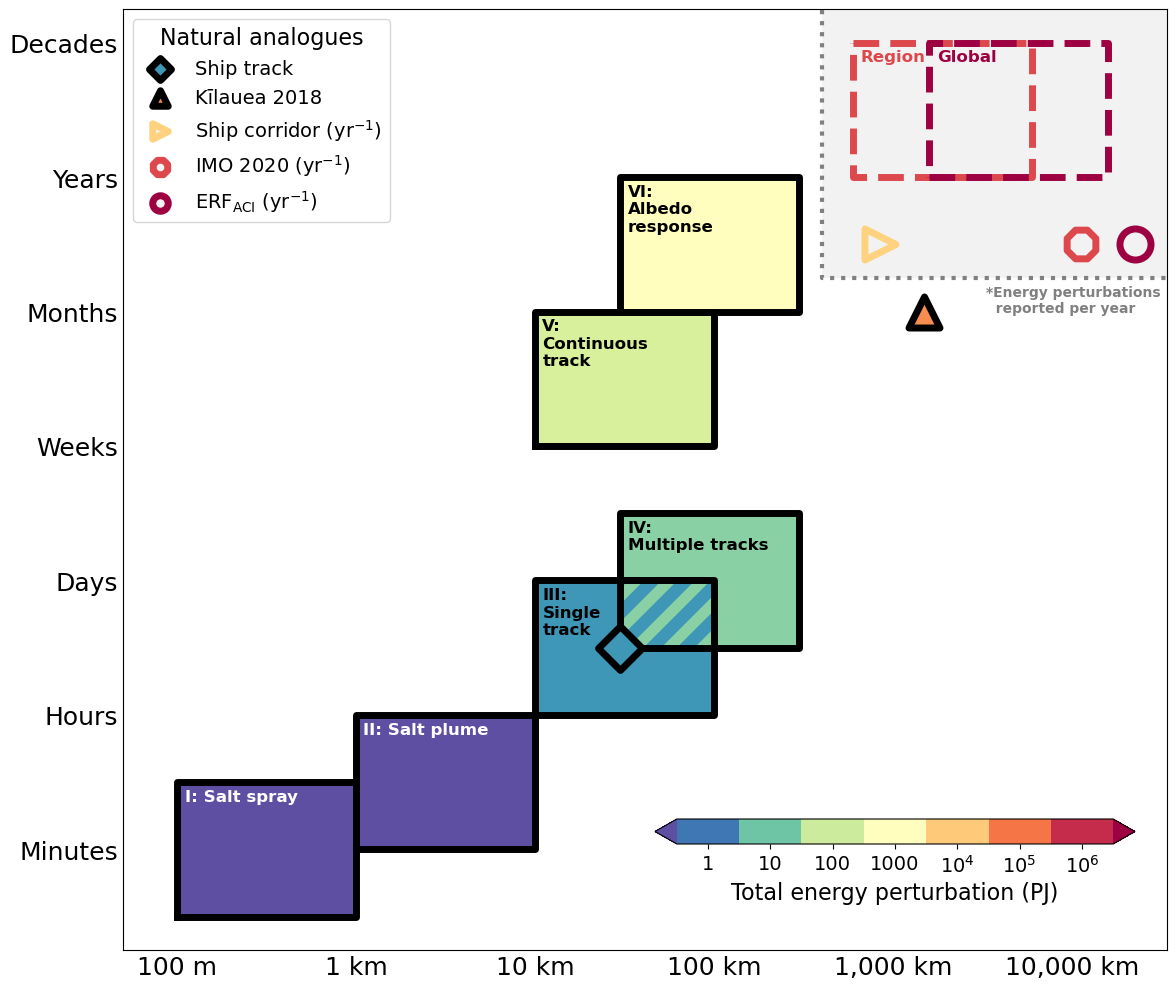

In [47]:
plt.figure(figsize=(12,10))
plt.clf()

fs = 18

ax = plt.subplot(111)

#Stage I: Salt sprayer
norm = (1-7)/8
plt.plot([100,1000,1000,100,100],[-.5,-.5,0.5,0.5,-.5],c='k',lw=5)
plt.fill_between(np.array([100,1000]),2*[-0.5],2*[0.5],facecolor=cm.Spectral_r(norm))
plt.text(1.1*100,-0.05+0.5,s='I: Salt spray',fontsize=fs-6,fontweight='bold',color='w',ha='left',va='top')

#Stage II: Salt plume
norm = (1-4)/8
plt.plot(np.array([1,10,10,1,1])*1000,[0,0,1,1,0],c='k',lw=5)
plt.fill_between(np.array([1,10])*1000,2*[0],2*[1],facecolor=cm.Spectral_r(norm))
plt.text(1.1*1*1000,-0.05+1,s='II: Salt plume',fontsize=fs-6,fontweight='bold',color='w',ha='left',va='top')

#Stage III: Single track
norm = (1+0)/8
plt.plot(np.array([10,100,100,10,10])*1000,[1,1,2,2,1],c='k',lw=5,ls='solid')
plt.fill_between(np.array([10,100])*1000,2*[1],2*[2],facecolor=cm.Spectral_r(norm))
plt.text(1.1*10*1000,-0.05+2,s='III:\nSingle\ntrack',fontsize=fs-6,fontweight='bold',color='k',ha='left',va='top')

#Stage IV: Multiple tracks
norm = (1+1)/8
plt.plot(np.array([10,100,100,10,10])*3*1000,0.5+np.array([1,1,2,2,1]),c='k',lw=5,ls='solid')
plt.fill_between(np.array([10,100])*3000,2*[1.5],2*[2.5],facecolor=cm.Spectral_r(norm),zorder=0)
plt.fill_between(np.array([30,100])*1000,2*[1.5],2*[2],facecolor=cm.Spectral_r(norm),zorder=1,
                 hatch='/',hatch_linewidth=9,edgecolor=cm.Spectral_r(1/8)) #Overlap
plt.text(1.1*10*3*1000,-0.05+2.5,s='IV:\nMultiple tracks',fontsize=fs-6,fontweight='bold',color='k',ha='left',va='top')

#plt.text(1000,2,s='Discrete\nProcess\nStudies',fontsize=fs-4,fontweight='bold',color='k',ha='left',va='top')

#Stage V: Continous track
norm = (1+2)/8
plt.plot(np.array([10,100,100,10,10])*1000,[3,3,4,4,3],c='k',lw=5,ls='solid')
plt.fill_between(np.array([10,100])*1000,[3,3],[4,4],facecolor=cm.Spectral_r(norm))
plt.text(1.1*10*1000,-0.05+4,s='V:\nContinuous\ntrack',fontsize=fs-6,fontweight='bold',color='k',ha='left',va='top')

#Stage VI: Albedo response test
norm = (1+3)/8
plt.plot(np.array([10,100,100,10,10])*3*1000,[4,4,5,5,4],c='k',lw=5,ls='solid')
plt.fill_between(np.array([10,100])*3*1000,[4,4],[5,5],facecolor=cm.Spectral_r(norm))
plt.text(1.1*10*3*1000,-0.05+5,s='VI:\nAlbedo\nresponse',fontsize=fs-6,fontweight='bold',color='k',ha='left',va='top')

#plt.text(3*1000,4.5,s='Sustained\nExperiments',fontsize=fs-4,fontweight='bold',color='k',ha='left',va='center')

#Stage VII: Regional climate response trial
norm = (1+6)/8
plt.plot(np.array([1e3,1e4,1e4,1e3,1e3])*6*100,[6,6,5,5,6],c=cm.Spectral_r(norm),lw=5,ls='dashed')
plt.text(1.1*1e3*6*100,-0.05+6,s='Region',fontsize=fs-6,fontweight='bold',color=cm.Spectral_r(norm),ha='left',va='top')

#Stage VIII: Global climate response trial
norm = (1+7)/8
plt.plot(np.array([1e3,1e4,1e4,1e3,1e3])*1.6*1000,[5,5,6,6,5],c=cm.Spectral_r(norm),lw=5,ls='dashed')
plt.text(1.1*1e3*1.6*1000,-0.05+6,s='Global',fontsize=fs-6,fontweight='bold',color=cm.Spectral_r(norm),ha='left',va='top')

#plt.text(1e3*5*100,0.05+6,s='(Conditional) Deployment',fontsize=fs-4,fontweight='bold',color='k',ha='left',va='bottom')

#Ship track
plt.scatter(30000,1.5,s=500,edgecolor='k',lw=5,color=cm.Spectral_r((1+0)/8),marker='D',zorder=11,label='Ship track')

#Kilauea natural experiment
plt.scatter(15*100*1000,4,s=500,edgecolor='k',lw=5,marker='^',color=cm.Spectral_r((1+5)/8),label='Kīlauea 2018')

#SEA shipping corridor per year
plt.scatter(850*1000,4.5,s=500,color='.95',lw=5,marker='>',edgecolor=cm.Spectral_r((1+4)/8),label=r'Ship corridor ($\mathrm{yr}^{-1}$)')

#IMO 2020 per year
plt.scatter(np.sqrt(np.pi)*Re,4.5,s=500,color='.95',lw=5,marker='8',edgecolor=cm.Spectral_r((6+1)/8),label=r'IMO 2020 ($\mathrm{yr}^{-1}$)')

#Global ERFaci per year
plt.scatter(2*np.sqrt(np.pi)*Re,4.5,s=500,color='.95',lw=5,marker='o',edgecolor=cm.Spectral_r((7+1)/8),label=r'$\mathrm{ERF_{ACI}}$ ($\mathrm{yr}^{-1}$)')

#Per year region
plt.fill_between([400*1000,1e8],[4.25,4.25],[7,7],facecolor='.95',zorder=0)
plt.plot([400*1000,400*1000,1e8,],[7,4.25,4.25],c='.5',lw=3,ls='dotted')
plt.text(3300*1000,4.2,'*Energy perturbations\n  reported per year',color='.5',fontsize=fs-8,ha='left',va='top',fontweight='bold')

plt.xscale('log')

plt.ylim(-0.75,6.25)
plt.xlim(50,1.5*2*np.sqrt(np.pi)*Re)

plt.yticks(np.arange(7),['Minutes','Hours','Days','Weeks','Months', 'Years','Decades'],fontsize=fs)

ax.tick_params(axis='both', length=0)
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.xaxis.set_minor_locator(ticker.NullLocator())
plt.xticks(list(10**np.arange(2,7+1)),['100 m','1 km','10 km','100 km','1,000 km','10,000 km'],fontsize=fs)

plt.legend(frameon=True,fontsize=fs-4,loc=2,markerscale=0.5,title='Natural analogues',title_fontsize=fs-2)

#Colorbar inset
cb_ax = plt.axes([0.55, 0.15, 0.4, 0.025])  # [left, bottom, width, height]
#shading = plt.scatter(np.nan,np.nan,c=1,vmin=-1,vmax=7,cmap=cm.Spectral_r)
shading = plt.contourf([np.nan,np.nan],[np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]],
                       levels=np.arange(0,7.01),
                       cmap = cm.Spectral_r,
                       extend='both')
cbar = plt.colorbar(shading, cax=cb_ax, orientation='horizontal',extend='both',ticks=np.arange(.5,6.6))
cbar.set_label('Total energy perturbation (PJ)',fontsize=fs-2)
cbar.ax.set_xticklabels([1,10,100,1000,r'$10^4$',r'$10^5$',r'$10^6$'])
cbar.ax.tick_params(labelsize=fs-4)

plt.tight_layout()

plt.show()